# Toy Model 2D CNN 

This notebook get's the training and testing data for toy model data and trains two seperate 2D CNN models- one with Image as input and other woth Image and XAUGs (r1, r2,$\theta$, z)

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow.keras.utils
from tensorflow.keras.utils import multi_gpu_model
import pandas as pd

from datetime import datetime
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] < 2, \
    "This notebook does not worl for TensorFlow 2.0"

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle
from tensorflow.keras import *

import os
import pickle
# from numba import jit

TensorFlow version:  1.13.1


## Import data:
Using jetImagesTrain.npz and jetImagesTest.npz to train and test the neural network respectively.

In [3]:
grid = 16
data_train = np.load('data/jetImagesTrain.npz')
data_test = np.load('data/jetImagesTest.npz')
# feat_all = [key for key in data_train.keys()]
# feat_all.remove('labels')
data_train.files

['jetImages', 'theta', 'radii', 'z', 'labels']

Text(0.5, 1.0, 'Toy Model $Z$')

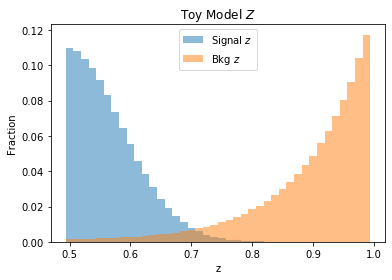

In [4]:
hist1, bins1 = np.histogram(data_train['z'][data_test['labels'][:,1]==1], bins=40, range = [0.5,1])
hist2, bins2 = np.histogram(data_train['z'][data_test['labels'][:,0]==1], bins=bins1)
fig, ax = plt.subplots()
ax.bar(bins1[:-1], hist1/(np.sum(hist1)), width=np.diff(bins1), alpha = 0.5, label = r"Signal $z$")
ax.bar(bins2[:-1], hist2/(np.sum(hist2)), width=np.diff(bins2), alpha = 0.5, label = r"Bkg $z$")
plt.xlabel('z')
plt.ylabel("Fraction")
legend = plt.legend()
plt.title(r"Toy Model $Z$")

## Image only CNN

Build DNN:

In [5]:
def build_model():
    input1 = layers.Input(shape = (grid, grid, 1), name = 'input')
    x = layers.Conv2D(32, (5, 5), activation='relu', name = "conv1", padding = 'same')(input1)
    x = layers.Conv2D(32, (3, 3), activation='relu', name = 'conv2', padding = 'same')(x)
    x = layers.Conv2D(32, (2, 2), activation='relu', name = 'conv3', padding = 'same')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPool2D((2, 2), name = 'maxpool1')(x)
    x = layers.Flatten(name = 'flatten')(x)
    x = layers.Dense(64, activation='relu', name = 'dense1')(x)
    output = layers.Dense(2, activation='softmax', name = 'softmax')(x)
    model = models.Model(inputs=input1, outputs=output)
    opt=keras.optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad = False)
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['mean_squared_error', 'binary_crossentropy', 'accuracy'])
    return model

Initialize model:

In [6]:
CNN = build_model()

Test model's prediction $before$ training:

In [7]:
X_batch = data_train['jetImages'][:10]
Y_batch = data_train['labels'][:10]
example_result = CNN.predict(x = X_batch)
results = CNN.evaluate(x = X_batch, y = Y_batch )
print(results)

Now train!

In [8]:
checkpoint_path = "model/CNN2D_1mil_1.h5"
if not os.path.exists("model"):
    os.mkdir("model")

model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto',
                                   period=1)
EPOCHS = 80
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = CNN.fit(data_train['jetImages'], data_train['labels'],
                           epochs=EPOCHS, validation_split = 0.2, verbose = 1,
                           callbacks=[early_stop, model_checkpoint])
CNN.save(checkpoint_path)

In [9]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.to_csv('history_1.csv',index=False)

Load best weights.

In [10]:
best_model = keras.models.load_model('model/CNN2D_1mil_1.h5')
best_model.summary()
results = best_model.evaluate(data_test['jetImages'], data_test['labels'], verbose = 1)
print(results)

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

In [11]:
predict = best_model.predict(data_test['jetImages'])

In [12]:
# Plot ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(data_test['labels'][:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.4f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
sig = predict[data_test['labels'][:,1]==1][:,1]
bkg = predict[data_test['labels'][:,0]==1][:,1]

bins = np.linspace(0, 1, 20)

plt.hist(sig, bins, alpha=0.5, label='Signal')
plt.hist(bkg, bins, alpha=0.5, label='Background')
# plt.ylim(0,25000)
plt.yscale('log')
plt.legend(loc='upper center')
plt.xlabel('Prediction')
plt.show()

## CNN with XAUGs

Build DNN:

In [14]:
def build_model():
    input1 = layers.Input(shape = (grid, grid,1))
    x = layers.Conv2D(32, (5, 5), activation='relu', padding='same', name = 'conv1')(input1)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'conv2')(x)
    x = layers.Conv2D(32, (2, 2), activation='relu', padding='same', name = 'conv3')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPool2D((2, 2), name = 'maxpool2x2_1')(x)
    x1 = layers.Flatten(name = 'flatten')(x)
    input2 = layers.Input(shape=(2,))
    input3 = layers.Input(shape=(1,))
    input4 = layers.Input(shape=(1,))
    x = layers.concatenate(inputs = [x1, input2, input3, input4], axis=-1, name='concat')
    x = layers.Dense(64, activation='relu', name = 'relu1')(x)
    x = layers.Dense(128, activation='relu', name = 'relu2')(x)    
    output = layers.Dense(2, activation='softmax', name = 'softmax')(x)
    model = models.Model(inputs=[input1, input2, input3, input4], outputs=output)
    
    opt=keras.optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad = False)
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['mean_squared_error', 'binary_crossentropy', 'accuracy'])
    return model

Initialize model:

In [15]:
CNN_XAUG = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Test model's prediction $before$ training:

In [16]:
X_batch1 = data_train['jetImages'][:10]
X_batch2 = data_train['radii'][:10]
X_batch3 = data_train['theta'][:10]
X_batch4 = data_train['z'][:10]
Y_batch = data_train['labels'][:10]
example_result = CNN_XAUG.predict(x = [X_batch1,X_batch2,X_batch3,X_batch4])
results = CNN_XAUG.evaluate(x = [X_batch1,X_batch2,X_batch3,X_batch4], y = Y_batch )
print(results)

10/10 [==============================] - 0s 7ms/sample - loss: 0.6936 - mean_squared_error: 0.2502 - binary_crossentropy: 0.6936 - acc: 0.5000
[0.6935637593269348, 0.25020826, 0.69356376, 0.5]


Now train!

In [17]:
XAUG_input = [data_train['jetImages'], data_train['radii'],
              data_train['theta'], data_train['z']]

In [18]:
checkpoint_path = "model/CNN2D_XAUG_1mil_1.h5"
if not os.path.exists("model"):
    os.mkdir("model")

model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto',
                                   period=1)  #save_freq='epoch',   
EPOCHS = 80
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = CNN_XAUG.fit(XAUG_input, data_train['labels'],
                       epochs=EPOCHS, validation_split = 0.2, verbose = 1,
                       callbacks=[early_stop, model_checkpoint])
CNN_XAUG.save(checkpoint_path)

Train on 800000 samples, validate on 200000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/80
799936/800000 [============================>.] - ETA: 0s - loss: 0.0113 - mean_squared_error: 0.0028 - binary_crossentropy: 0.0113 - acc: 0.9965
Epoch 00001: val_loss improved from inf to 0.00762, saving model to model/CNN2D_XAUG_1mil_1.h5
800000/800000 [==============================] - 654s 817us/sample - loss: 0.0113 - mean_squared_error: 0.0028 - binary_crossentropy: 0.0113 - acc: 0.9965 - val_loss: 0.0076 - val_mean_squared_error: 0.0018 - val_binary_crossentropy: 0.0076 - val_acc: 0.9978
Epoch 2/80
799968/800000 [============================>.] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0018 - binary_crossentropy: 0.0077 - acc: 0.9977
Epoch 00002: val_loss improved from 0.00762 to 0.00690, saving model to model/CNN2D_XAUG_1mil_1.h5
800000/800000 [==============================] - 935s 1ms/sample - loss: 0.0077 - mean_squared_error: 0.0018 - binary_crossentropy: 0.0

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.to_csv('history_XAUG_1.csv',index=False)

In [20]:
XAUG_test = [data_test['jetImages'], data_test['radii'],
              data_test['theta'], data_test['z']]

Load best weights.

In [21]:
best_model = keras.models.load_model('model/CNN2D_XAUG_1mil_1.h5')
best_model.summary()
results = best_model.evaluate(XAUG_test, data_test['labels'], verbose = 1)
print(results)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 16, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 16, 16, 32)   9248        conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 16, 16, 32)   4128        conv2[0][0]                      
__________________________________________________________________________________________________
dropout (D

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

In [22]:
predict_XAUG = best_model.predict(XAUG_test)

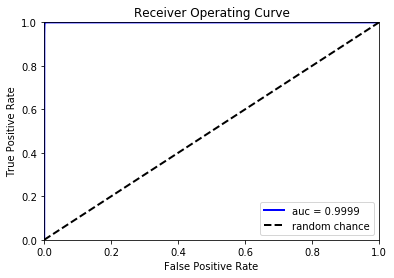

In [23]:
# Plot ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(data_test['labels'][:,1], predict_XAUG[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.4f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')
plt.legend(loc="lower right")
plt.show()

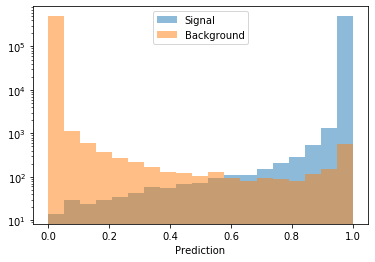

In [24]:
sig = predict_XAUG[data_test['labels'][:,1]==1][:,1]
bkg = predict_XAUG[data_test['labels'][:,0]==1][:,1]

bins = np.linspace(0, 1, 20)

plt.hist(sig, bins, alpha=0.5, label='Signal')
plt.hist(bkg, bins, alpha=0.5, label='Background')
# plt.ylim(0,25000)
plt.yscale('log')
plt.legend(loc='upper center')
plt.xlabel('Prediction')
plt.show()